In [1]:
import os
import sys
import itertools
from collections import defaultdict
import numpy as np

import torch
from torch import nn
print("Torch Version:", torch.__version__)

sys.path.append("../../utils/")
from PriorityQueue import PriorityQueue

# Simple RL
from simple_rl.tasks import NavigationWorldMDP
from simple_rl.tasks.navigation.NavigationStateClass import NavigationWorldState

import matplotlib.pyplot as plt
import matplotlib.style as style
# style.use('classic')
%matplotlib inline

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 55

%matplotlib inline
%load_ext autoreload
%autoreload 2

Torch Version: 0.5.0a0+ab6afc2


In [2]:
def log_boltzmann_dist(Q, temperature):
    """
    PyTorch softmax implementation seems stable, but log of softmax is not. 
    So log of boltzmann distribution is used.
    PyTorch Softmax Note:
        This function doesn't work directly with NLLLoss,
        which expects the Log to be computed between the Softmax and itself.
        Use log_softmax instead (it's faster and has better numerical properties).
    """
    return nn.LogSoftmax(dim=0)(Q/temperature)

def value_iteration(S, A, R, T, gamma, n_iters, goal_state_idx, convergence_eps=1e-3, 
                    boltzmann_temp=1e-4, dtype=torch.float32):
    
    # assert torch.all(R < 0)
    nS, nA = len(S), len(A)
    v_delta_max = float("inf")
    s_to_idx = {tuple(v):k for k,v in enumerate(S)}
    Q = torch.zeros(nS, nA, dtype=dtype)
    Pi = torch.log(torch.ones(nS, nA, dtype=dtype) / nA)
    # requires_grad = False isn't enough, so also detach tensor.
    # (reason: https://github.com/pytorch/pytorch/issues/166)
    V = torch.tensor(R.detach(), requires_grad=False)
    
    # Given goal
    V[goal_state_idx] = 0
    
    iterno = 0
    while iterno < n_iters and v_delta_max > convergence_eps:
        
        v_delta_max = 0
        for si, s in enumerate(S):
            
            v_s_prev = V[si].detach().item()
            if si == goal_state_idx or s.is_terminal():
                continue
            
            max_q = float("-inf")
            for ai, a in enumerate(A):
                
                s_prime = T(s,a)
                
                if s_prime is None: # outside envelope
                    continue
                    
                Q[si, ai] = R[si] + gamma * V[s_to_idx[tuple(s_prime)]].clone()
                q_s_a = Q[si, ai].detach().item()
                max_q = q_s_a if q_s_a > max_q else max_q
                
            Pi[si, :] = log_boltzmann_dist(Q[si, :].clone(), boltzmann_temp)
            V[si] = torch.exp(Pi[si, :].clone()).dot(Q[si, :].clone())
            
            v_delta_max = max(abs(v_s_prev - V[si].detach().item()), v_delta_max)
        
        iterno += 1
        
    if iterno == n_iters:
        print("VI max iterations reached @ {}.".format(iterno))
    else:
        print("VI converged @ {}.".format(iterno))
        
    return Pi, V, Q

def sample_trajectory(S, A, T, start_state, policy, given_goal, 
                      horizon=1000, greedy_selection=True):
    
    s_list = []
    a_list = []
    
    # state tuple -> idx
    s_to_idx = {tuple(v):k for k,v in enumerate(S)}
    given_goal_idx = s_to_idx[tuple(given_goal)]
    steps = 0
    
    ## start state
    s = start_state
    
    while steps < horizon:
        
        ## add state
        s_idx = s_to_idx[tuple(s)]
        s_list.append(S[s_idx])
        
        ## sample next state
        
        # policy  (Note: taking exp because the policy is log softmax)
        Pi_s = torch.exp(policy[s_idx]).detach().numpy()
        # action selection
        if greedy_selection:
            a_idx = int(Pi_s.argmax())
        else:
            a_idx = int(np.random.choice(len(A), p=Pi_s))
        
        a_list.append(A[a_idx])
        s = T(S[s_idx], A[a_idx])
        
        steps += 1
        
        # check if goal is given and reached
        if given_goal_idx is not None and s_idx == given_goal_idx:
            break
            
    return  s_list, a_list

def sample_trajectories(N, S, A, T, start_states, policy, given_goal, 
                        horizon=1000, greedy_selection=True):
    
    traj_list = []
    
    for i in range(N):
        
        s_list, a_list = sample_trajectory(S, A, T, start_states[i], policy, given_goal, horizon, greedy_selection)
        traj_list.append((s_list, a_list))
        
    return traj_list

def get_min_value_estimate_given_goal_greedy(max_traj_length, driving_cost, gamma):
    
    min_value = 0.
    for i in range(max_traj_length):
        min_value -= (gamma**i) * driving_cost
    return min_value

def likelihood(log_Pi, traj_list, s_to_idx, a_to_idx):
    
    lik = 0.
    # n_sa = 0.
    for (s_list, a_list) in traj_list:
        for i in range(len(s_list)):
            s, a = s_list[i], a_list[i]
            lik += log_Pi[s_to_idx[tuple(s)]][a_to_idx[a]]
            # n_sa += 1
    return lik

def log_likelihood(Pi, traj_list, s_to_idx, a_to_idx):
    
    loglik = 0.
    # n_sa = 0.
    for (s_list, a_list) in traj_list:
        for i in range(len(s_list)):
            s, a = s_list[i], a_list[i]
            loglik += torch.log(Pi[s_to_idx[tuple(s)]][a_to_idx[a]])
            # n_sa += 1
    return loglik

# Visualization functions 
import io
import imageio
from PIL import Image
from IPython import display

def read_pil_image_from_plt(plt):
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    return Image.open(buf)

def create_gif(img_generator, cmap=plt.cm.viridis, gif_name="./__gif_sample.gif", fps=10,
               figsize=(4, 4), title=None, display=False):
    with imageio.get_writer(gif_name, mode='I', fps=fps) as writer:
        for img in img_generator():
            # Append to GIF
            writer.append_data(np.array(img))
            
            # Wait to draw - only for online visualization
            if display:
                plt.imshow(img)
                display.clear_output(wait=True)
                display.display(plt.gcf())
        plt.clf()
    return

def convert_to_grid(nvmdp, S, state_values):
    
    grid = np.zeros((nvmdp.height, nvmdp.width))
    
    for si, s in enumerate(S):
        x, y = s
        row, col = nvmdp._xy_to_rowcol(x, y)
        grid[row, col] = state_values[si]
    return grid

def get_grad_evolution_images(nvmdp, S, R_grid, expert_traj, R_grads_evolution, boltzmann_temp, 
                              figsize=(40,20), R_kind=""):

    for i in range(len(R_grads_evolution)):
        
        plt.close('all')
        plt.figure(figsize=figsize)
        nvmdp.visualize_grid(R_grid, trajectories=expert_traj, cmap=plt.cm.Reds_r,
                             state_space_cmap=False, show_colorbar=True, fig=fig, subplot_str="121",
                             title="Navigation IRL MDP(with true reward). Expert Path (black).", end_marker="*c")
        nvmdp.visualize_grid(convert_to_grid(nvmdp, S, R_grads_evolution[i]), trajectories=[expert_traj[0][:i+1]], 
                             state_space_cmap=False,  traj_marker='-b',
                             cmap=plt.cm.Reds_r, show_colorbar=True, fig=fig, subplot_str="122",
                             title="MLIRL Gradients. {}, temp: {}, step: {}.".format(R_kind, boltzmann_temp, i+1))
        yield read_pil_image_from_plt(plt)
        plt.clf()

In [3]:
class RectangularObstacle(object):
    
    def __init__(self, x, y, w, h):
        
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.points = [(x+i, y+j) for j in range(h) for i in range(w)]
    
    def intersects(self, o2):
        
        x1, y1, w1, h1 = o2.x, o2.y ,o2.w, o2.h
        
        # check if rect is on the left or right side of another one
        if self.x + self.w < x1\
            or self.x > x1 + w1:
            return False
        
        # check if rect is on the top or bottom side of another one
        if self.y + self.h < y1 \
            or self.y > y1 + h1:
            return False
        
        return True
    
    def __eq__(self, o2):
        return self.intersects(o2)
        
    def __call__(self):
        return self.points
    
    def __repr__(self):
        return "Obstacle at (x,y) = ({},{}) of size (w,h) = ({},{})".format(self.x, self.y, self.w, self.h)

def generate_obstacles(grid_w, grid_h, n_obstacles, 
                       obstacle_w_mu=3, obstacle_w_std=3,
                       obstacle_h_mu=3, obstacle_h_std=3,
                       max_search_tries=100):

    obstacle_list = []
    count = 0
    search_tries = 0
    while count < n_obstacles:
        
        w = int(max(np.ceil(np.random.normal(obstacle_w_mu, obstacle_w_std)), 1))
        h = int(max(np.ceil(np.random.normal(obstacle_h_mu, obstacle_h_std)), 1))
        
        # restrict x, y so that obstacle is inside the desired region
        x, y = np.random.randint(1, grid_w-w+1), np.random.randint(1, grid_h-h+1)
        
        ob = RectangularObstacle(x, y, w, h)
        
        if ob not in obstacle_list:
            obstacle_list.append(ob)
            count += 1
            search_tries = 0
        else:
            search_tries += 1
            if search_tries < max_search_tries:
                continue
            else:
                print("Couldn't find space for more obstacles. Generated: {}".format(count))
                break
        
    return obstacle_list

heuristic_l2 = lambda s1, s2: np.linalg.norm(np.array(s1) - np.array(s2))
def astar_find_path(start, goal, actions, trans_func, cost_fn=lambda s: 1, heuristic_fn=heuristic_l2):
    
    frontier = PriorityQueue()
    frontier.append([cost_fn(start)+heuristic_fn(start, goal), cost_fn(start), start])
    explored = defaultdict(lambda: False)
    cost = defaultdict(lambda: np.float("inf"))
    parent = defaultdict(lambda: None)
    path = []
    
    while frontier.size():
        
        f, g, s = frontier.pop()
        explored[s] = True
        
        if s == goal:
            
            path = []
            state = goal
            path.append(state)
            while parent[state]:
                path.append(parent[state])
                state = parent[state]
            return path[::-1]
        
        for a in actions:
            
            sp = trans_func(s, a)
            if not explored[sp] and sp not in frontier:
                
                g_new = g + cost_fn(sp)
                f_new = g_new + heuristic_fn(sp, goal)
                
                # prevent cycles
                if g_new < cost[sp]:
                    frontier.append((f_new, g_new, sp))
                    parent[sp] = s
                    cost[sp] = g_new
    return None
# traj = astar_find_path(S[0], S[10], A, T, cost_fn=lambda s: -R_s(s))

def sample_trajectories(start_states, goal_states, 
                        shortest_path_fn = lambda s, g: astar_find_path(s, g, A, T, cost_fn=lambda s: -R_s(s))):
    
    traj_list = []
    for i in range(len(start_states)):
        start = start_states[i]
        goal = goal_states[i]
        traj_list.append(shortest_path_fn(start, goal))
    return traj_list 

def state_id_to_feature(state_id):
    
    sigma = 0.1
    
    if state_id == 0:
        if np.random.random() > 0.5:
            mu1 = -0.5
            mu2 = -0.5
        else:
            mu1 = 0.5
            mu2 = 0.5
        return [np.random.normal(mu1, sigma), np.random.normal(mu2, sigma)]
    else:
        if np.random.random() > 0.5:
            mu1 = -0.5
            mu2 = 0.5
        else:
            mu1 = 0.5
            mu2 = -0.5
        return [np.random.normal(mu1, sigma), np.random.normal(mu2, sigma)]

Couldn't find space for more obstacles. Generated: 53


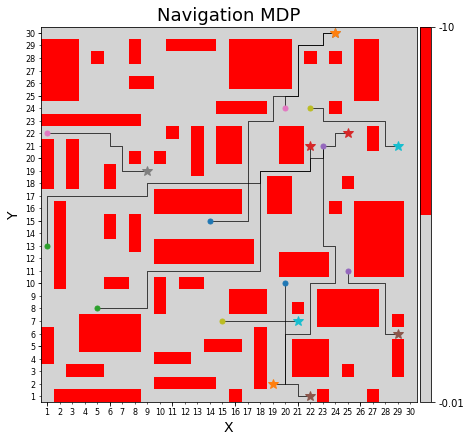

(<Figure size 504x504 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11aeb8390>)

In [4]:
np.random.seed(1)
torch.manual_seed(1)

obstacle = lambda x, y, w, h: [(x+i, y+j) for j in range(h) for i in range(w)]

W, H = 30, 30
n_obstacles = 100

nvmdp = NavigationWorldMDP(
    
    width = W, height = H,
    nav_cell_types = ['lightgrey', "red"],
    nav_cell_rewards = [-0.01, -10],
    nav_cell_p_or_locs = [1., 
                          list(itertools.chain(*[o() for o in generate_obstacles(
                              W, H, n_obstacles, max_search_tries=100)]))],
    goal_cell_types = [],
    goal_cell_rewards = [],
    goal_cell_locs = [],
    slip_prob = 0.0, step_cost = 0,
    gamma = 0.95
)
S = nvmdp.get_all_states()
s_to_idx = {tuple(v):k for k,v in enumerate(S)}
R_s = nvmdp._reward_func_state_only
R = torch.tensor([R_s(s) for s in S], requires_grad=True)
R_grid = convert_to_grid(nvmdp, S, R)
A = nvmdp.get_actions()
a_to_idx = {a:i for i,a in enumerate(A)}
T = nvmdp.transition_func

# Features
state_ids = [nvmdp.map_state_cell_id[tuple(nvmdp._xy_to_rowcol(*s))] for s in S]
phi = np.asarray([state_id_to_feature(s_id) for s_id in state_ids])

# Sample demonstrations
n_traj = 10
nvmdp.set_traj_init_cell_types(["lightgrey"])
traj_list = sample_trajectories(nvmdp.sample_init_states(n_traj), nvmdp.sample_init_states(n_traj))

nvmdp.visualize_grid(trajectories=traj_list,
                     state_space_cmap=True, 
                     show_rewards_colorbar=True,
                     cmap=plt.cm.Reds_r,
                     show_colorbar=True, 
                     init_marker=".",
                     end_marker="*")

Text(0.5,1,'Features')

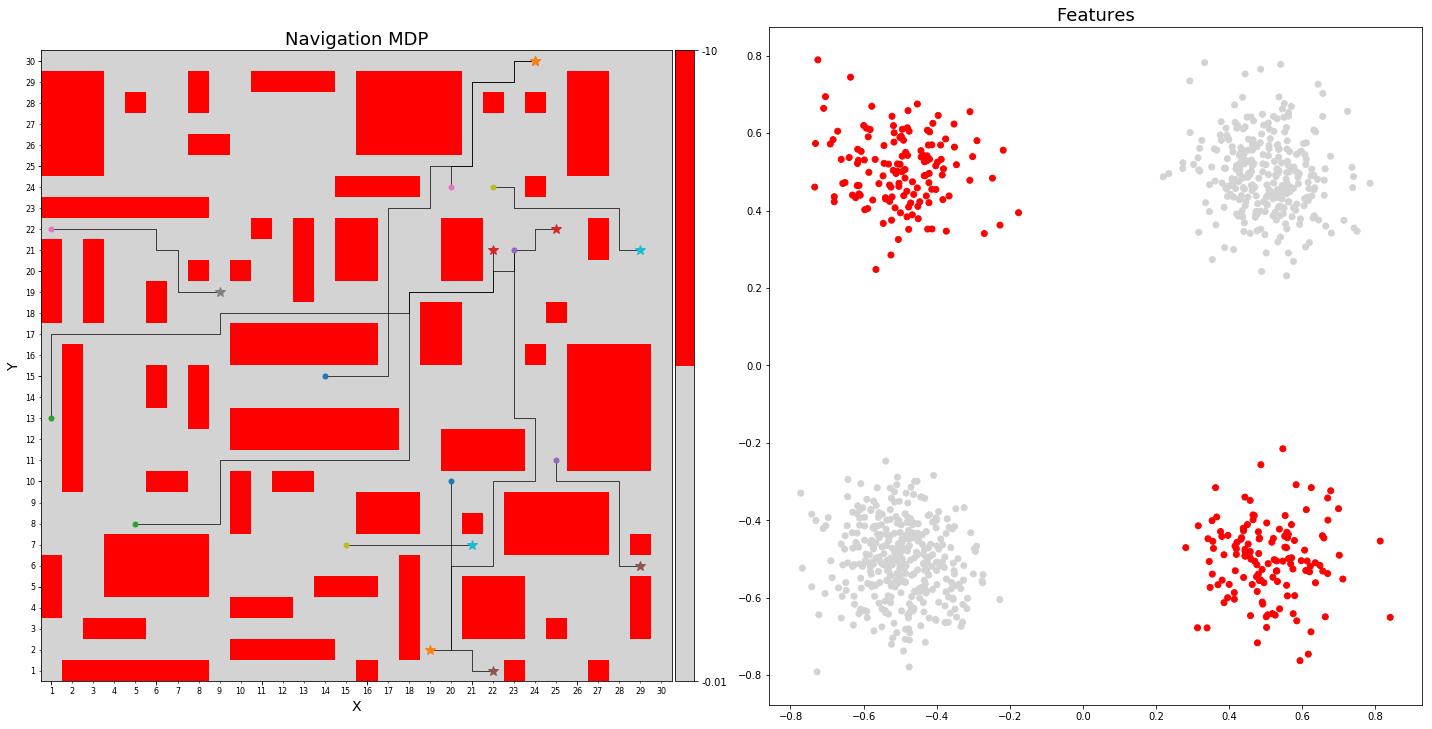

In [5]:
fig = plt.figure(figsize=(20,10))
colors = ["lightgrey", "red"]
ax = fig.add_subplot("121")
fig, ax = nvmdp.visualize_grid(trajectories=traj_list, 
                     state_space_cmap=True,
                     show_rewards_colorbar = True,
                     cmap=plt.cm.Reds_r, 
                     show_colorbar=True, 
                     init_marker=".",
                     end_marker="*", fig=fig, ax=ax, plot=False)

ax = fig.add_subplot("122")
plt.scatter(phi[:,0], phi[:,1], c=[colors[s] for s in state_ids])
plt.tight_layout()
plt.title("Features")